In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm
import matplotlib.pyplot as plt

# Variational Autoencoder (VAE)
The goal is to define and train a variational autoencoder on the MNIST dataset. While the simple autoencoder is mainly used for dimensionality reduction, the variational autoencoder is used for data generation. While the simple autoencoder learns a deterministic mapping to a lower-dimensional space, the variational autoencoder learns a probabilistic mapping to a lower-dimensional space, by learning the parameters of the probability distribution that describes the data (mean and standard deviation). A sample from this distribution is then used to generate new data points.

## Dataset
We use the MNIST dataset from torchvision.

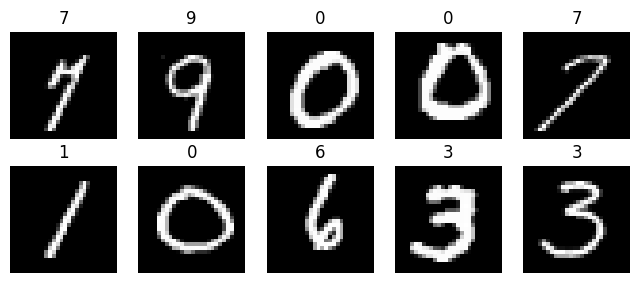

In [89]:
train_data = datasets.MNIST(
    root="../data", train=True, download=True, transform=ToTensor()
)
test_data = datasets.MNIST(
    root="../data", train=False, download=True, transform=ToTensor()
)

figure = plt.figure(figsize=(8, 3.2))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="binary_r")

In [90]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

## VAE model
The variational autoencoder model consists of two parts: the encoder and the decoder. The encoder consists of convolutional layers, then linear layers to obtain the distribution parameters, and the decoder consists of linear layers and transposed convolutional layers. The encoder reduces the input image to a lower-dimensional latent space, and the decoder reconstructs the image from the latent space.

In [91]:
class VAE(nn.Module):
	def __init__(self, latent_dim: int):
		super(VAE, self).__init__()
		self.latent_dim = latent_dim
		self.encoder = nn.Sequential(
			nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
			nn.ReLU(),
			nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
			nn.ReLU(),
			nn.Flatten(),
			nn.Linear(16 * 7 * 7, 32),
			nn.ReLU(),
		)
		self.fc_mu = nn.Linear(32, latent_dim)
		self.fc_log_var = nn.Linear(32, latent_dim)
		self.decoder = nn.Sequential(
			nn.Linear(latent_dim, 32),
			nn.ReLU(),
			nn.Linear(32, 16 * 7 * 7),
			nn.ReLU(),
			nn.Unflatten(1, (16, 7, 7)),
			nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
			nn.ReLU(),
			nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
			nn.Sigmoid()
		)
	
	def encode(self, x: torch.tensor) -> torch.tensor:
		x = self.encoder(x)
		mu = self.fc_mu(x)
		log_var = self.fc_log_var(x)
		return mu, log_var
		
	def reparameterize(self, mu: torch.tensor, log_var: torch.tensor) -> torch.tensor:
		std = torch.exp(0.5 * log_var)
		eps = torch.randn_like(std)
		return mu + eps * std

	def decode(self, z: torch.tensor) -> torch.tensor:
		return self.decoder(z)
	
	def forward(self, x: torch.tensor) -> torch.tensor:
		mu, log_var = self.encode(x)
		z = self.reparameterize(mu, log_var)
		return self.decode(z), mu, log_var

## Training the model
To train the VAE, we need to define a special loss function that uses the reconstruction loss (how well the model reconstructs the input) and the KL divergence (how well the model learns the distribution of the data).

In [92]:
def vae_loss(x: torch.tensor, x_hat: torch.tensor, mu: torch.tensor, log_var: torch.tensor, beta: float = 1) -> torch.tensor:
	reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction="sum")
	kl_divergence = 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
	return reconstruction_loss - beta * kl_divergence, reconstruction_loss, kl_divergence

In [93]:
latent_dim, lr, num_epochs, beta = 8, 1e-3, 8, 1
vae = VAE(latent_dim)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

In [94]:
train_loss, test_loss = [], []

for epoch in  (pbar := tqdm(range(num_epochs), desc="Epochs")):

	for batch_idx, (images, _) in enumerate(train_dataloader):
		optimizer.zero_grad()
		x_hat, mu, log_var = vae(images)
		loss, reconstruction_loss, kl_divergence = vae_loss(images, x_hat, mu, log_var, beta)
		loss.backward()
		optimizer.step()
		train_loss.append((loss.item(), reconstruction_loss.item(), kl_divergence.item()))
		pbar.set_postfix(Batch_train=f"{batch_idx/len(train_dataloader) * 100:.2f}%", Train_loss=f"{loss.item():.3f}", Train_recon_loss=f"{reconstruction_loss.item():.3f}", Train_KLD=f"{kl_divergence.item():.3f}")
    
	with torch.no_grad():
		for batch_idx, (images, _) in enumerate(test_dataloader):
			x_hat, mu, log_var = vae(images)
			loss, reconstruction_loss, kl_divergence = vae_loss(images, x_hat, mu, log_var, beta)
			test_loss.append((loss.item(), reconstruction_loss.item(), kl_divergence.item()))
			
			pbar.set_postfix(Batch_test=f"{batch_idx/len(test_dataloader) * 100:.2f}%", Test_loss=f"{test_loss[-1][0]:.3f}", Test_recon_loss=f"{test_loss[-1][1]:.3f}", Test_KLD=f"{test_loss[-1][2]:.3f}")

Epochs: 100%|██████████| 8/8 [04:10<00:00, 31.30s/it, Batch_test=99.36%, Test_KLD=-208.786, Test_loss=2039.619, Test_recon_loss=1830.833]       


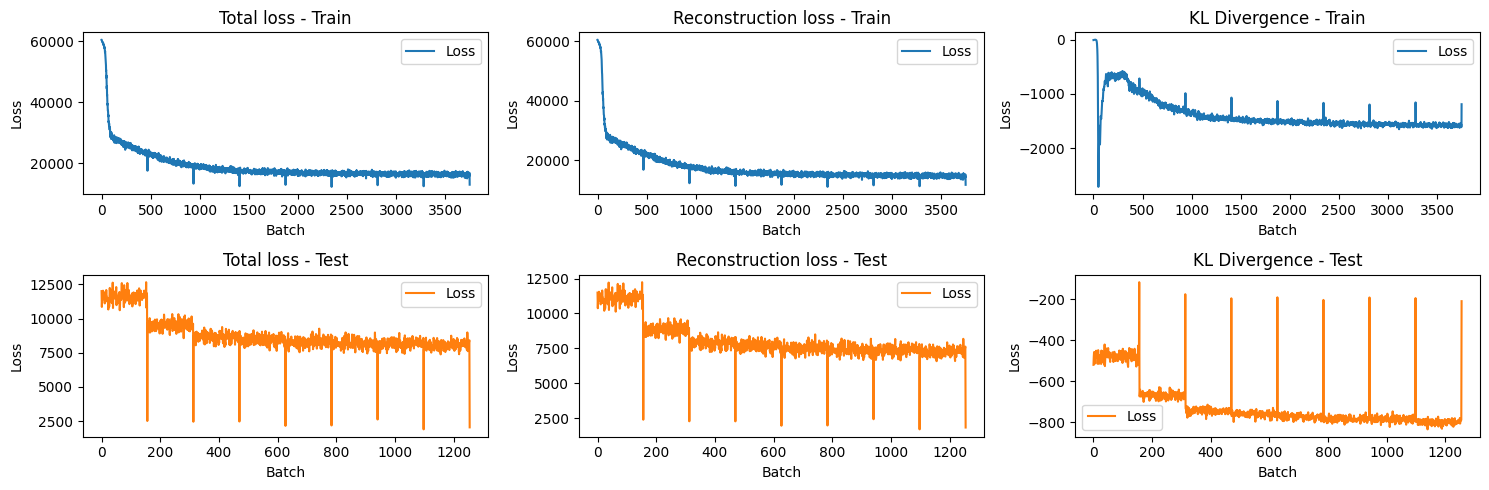

In [95]:
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

titles = ["Total loss", "Reconstruction loss", "KL Divergence"]

for i in range(3):
    for j in range(2):
        ax = axs[j, i]
        ax.set_title(f'{titles[i]} - {"Train" if j == 0 else "Test"}')
        ax.set_xlabel('Batch')
        ax.set_ylabel('Loss')
        data = train_loss if j == 0 else test_loss
        ax.plot([x[i] for x in data], label='Loss', color='C0' if j == 0 else 'C1')
        ax.legend()

plt.tight_layout()
plt.show()

## Visualizing the results
We visualize the original and reconstructed images for a few random samples from the test dataset.

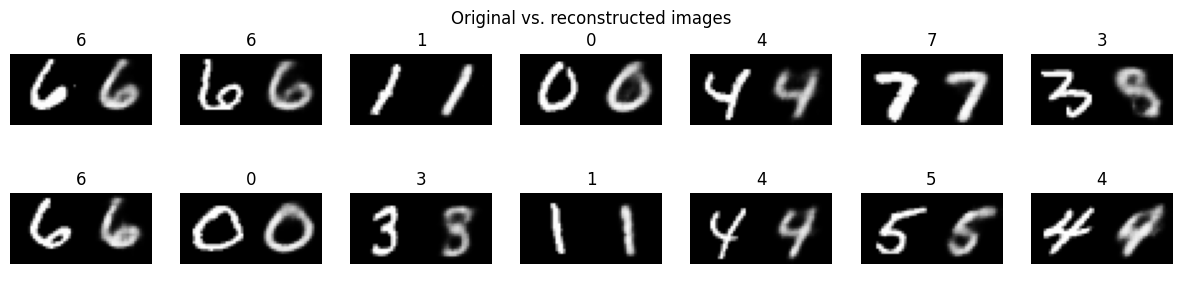

In [96]:
figure = plt.figure(figsize=(15, 3.3))
plt.title("Original vs. reconstructed images")
plt.axis("off")
cols, rows = 7, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    output, _, _ = vae(img.unsqueeze(0))
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(torch.cat([img.squeeze(), output.squeeze()], dim=1).detach().numpy(), cmap="binary_r")